# 1. California Housing Dataset: Problem Setup 

The task here is to take housing data from California and use this to predict the house sale price of a property.
The data is openly available in either `scikit-learn` or as a `.tar` file from elsewhere.

### In this notebook
- Download of the data
- Visualise the dataset
- Basic preprocessing

#### Reference: 
We have adapted this [textbook example](https://github.com/ageron/handson-ml2/blob/master/02_end_to_end_machine_learning_project.ipynb)

In [6]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

# Common imports
import numpy as np
import os
import pandas as pd

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

### 1.1 Obtaining the data
For consistency with the textbook example, we will download the data as is done in their notebook;

Alternatively, the data can be read in directly from sklearn using `fetch_california_housing()`.  

In [2]:
import os
import tarfile
import urllib

DOWNLOAD_ROOT = "https://raw.githubusercontent.com/ageron/handson-ml2/master/"
HOUSING_PATH = os.path.join("datasets", "housing")
HOUSING_URL = DOWNLOAD_ROOT + "datasets/housing/housing.tgz"

def fetch_housing_data(housing_url=HOUSING_URL, housing_path=HOUSING_PATH):
    if not os.path.isdir(housing_path):
        os.makedirs(housing_path)
    tgz_path = os.path.join(housing_path, "housing.tgz")
    urllib.request.urlretrieve(housing_url, tgz_path)
    housing_tgz = tarfile.open(tgz_path)
    housing_tgz.extractall(path=housing_path)
    housing_tgz.close()

In [3]:
# Where to save the figures
PROJECT_ROOT_DIR = "."

In [4]:
fetch_housing_data()

In [5]:
!ls

1_Problem_Setup.ipynb        5_FDRR.ipynb
2_Data_Preprocessing.ipynb   README.md
3_Pipeline_Preparation.ipynb datasets
4_Model_Selection.ipynb


The dataset, along with modified training and testing data will be saved in the `datasets` directory.

In [7]:
def load_housing_data(housing_path=HOUSING_PATH):
    csv_path = os.path.join(housing_path, "housing.csv")
    return pd.read_csv(csv_path)

The data can be summarised as follows:

In [8]:
housing = load_housing_data()
housing.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [12]:
print(f'The size of the data is: {housing.shape}')
print(f'The array requires {housing.values.nbytes/1000} kb')

The size of the data is: (20640, 10)
The array requires 1651.2 kb


**Remark:** 
It is worth noting that the data has only $10$ features.  This does not make it suitable for Frequent Directions as it is too low dimensionality. This is deferred until later while we deal with preprocessing the data to a usable format.

Using pandas we can also summarise the dataframe.

In [13]:
housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


All of these features except feature $9$, `ocean_proximity` are floats so we will have to deal with this.
Let's plot the features to understand their behaviour.

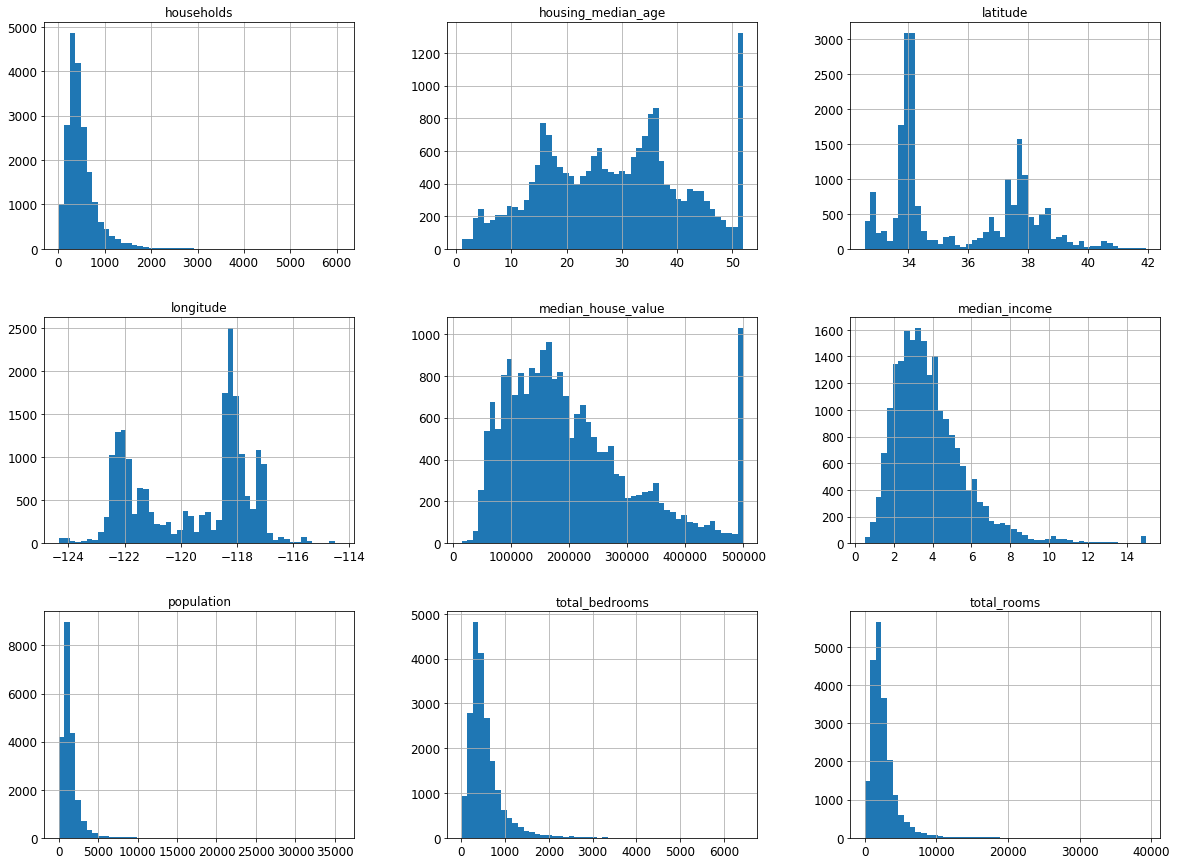

In [14]:
housing.hist(bins=50, figsize=(20,15))
plt.show()

### 1.2 Preprocessing
In this subsection we split the dataset into `train`,`validation` and `test` sets.
Although the notebook tutorial encodes these from scratch, we will use the sklearn functionality.

In [15]:
from sklearn.model_selection import train_test_split

In [16]:
# sets seed for reproducibility, might not be necessary
np.random.seed(10) 

In [18]:
train_set, test_set = train_test_split(housing, test_size=0.2, random_state=42)
test_set.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
20046,-119.01,36.06,25.0,1505.0,NaN,1392.0,359.0,1.6812,47700.0,INLAND
3024,-119.46,35.14,30.0,2943.0,NaN,1565.0,584.0,2.5313,45800.0,INLAND
15663,-122.44,37.80,52.0,3830.0,NaN,1310.0,963.0,3.4801,500001.0,NEAR BAY
20484,-118.72,34.28,17.0,3051.0,NaN,1705.0,495.0,5.7376,218600.0,<1H OCEAN
9814,-121.93,36.62,34.0,2351.0,NaN,1063.0,428.0,3.7250,278000.0,NEAR OCEAN


There are a couple of issues with the data, firstly, `total_bedrooms` seems to have some `NaN` values that need resolving.  Secondly, some features can have very long tails, e.g. `median_income`.  To resolve this, we will bin the feature.

In [19]:
housing["income_cat"] = pd.cut(housing["median_income"],
                               bins=[0., 1.5, 3.0, 4.5, 6., np.inf],
                               labels=[1, 2, 3, 4, 5])

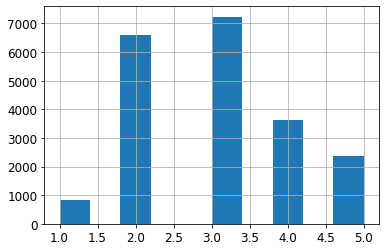

In [20]:
housing["income_cat"].hist()

In comparison to the non-binned feature:

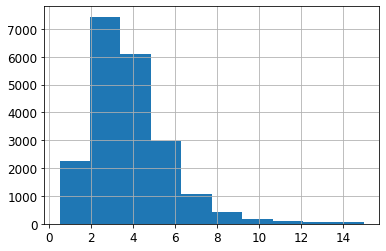

In [21]:
housing["median_income"].hist()

The purpose of binning is so that we can perform _stratified sampling_ over the dataset to generate a representative training and test set.

In [22]:
from sklearn.model_selection import StratifiedShuffleSplit

In [23]:
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in split.split(housing, housing["income_cat"]):
    strat_train_set = housing.loc[train_index]
    strat_test_set = housing.loc[test_index]

We can see the benefit of performing the binning and stratified sampling in the relative frequencies of sampled income categories.

In [24]:
strat_test_set["income_cat"].value_counts() / len(strat_test_set)

3    0.350533
2    0.318798
4    0.176357
5    0.114583
1    0.039729
Name: income_cat, dtype: float64

In [25]:
housing["income_cat"].value_counts() / len(housing)

3    0.350581
2    0.318847
4    0.176308
5    0.114438
1    0.039826
Name: income_cat, dtype: float64

These frequencies are similar and this can be formalised further.

In [26]:
def income_cat_proportions(data):
    return data["income_cat"].value_counts() / len(data)

train_set, test_set = train_test_split(housing, test_size=0.2, random_state=42)

compare_props = pd.DataFrame({
    "Overall": income_cat_proportions(housing),
    "Stratified": income_cat_proportions(strat_test_set),
    "Random": income_cat_proportions(test_set),
}).sort_index()
compare_props["Rand. %error"] = 100 * compare_props["Random"] / compare_props["Overall"] - 100
compare_props["Strat. %error"] = 100 * compare_props["Stratified"] / compare_props["Overall"] - 100

In [27]:
compare_props

,Overall,Stratified,Random,Rand. %error,Strat. %error
1,0.039826,0.039729,0.040213,0.973236,-0.243309
2,0.318847,0.318798,0.324370,1.732260,-0.015195
3,0.350581,0.350533,0.358527,2.266446,-0.013820
4,0.176308,0.176357,0.167393,-5.056334,0.027480
5,0.114438,0.114583,0.109496,-4.318374,0.127011


In [28]:
for set_ in (strat_train_set, strat_test_set):
    set_.drop("income_cat", axis=1, inplace=True)

### 1.3 Data visualisation
We will plot various features of the data to better understand it.

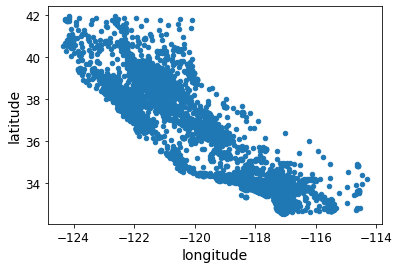

In [29]:
housing.plot(kind="scatter", x="longitude", y="latitude")

Although this roughly outlines California, we can improve the plot through a few different iterations.

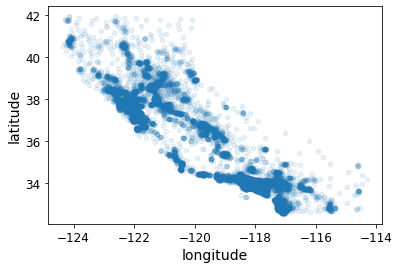

In [30]:
housing.plot(kind="scatter", x="longitude", y="latitude", alpha=0.1)

Using the `alpha` parameter allows us to control the opacity of the markers.  This shows a small amount of clustering around the Bay and SoCal.

This can be improved by adding a colour map to the densities as well as resizing the marker.

The colour is closer to red when the median house valuation is higher and the marker size is larger when the population in that area is larger.

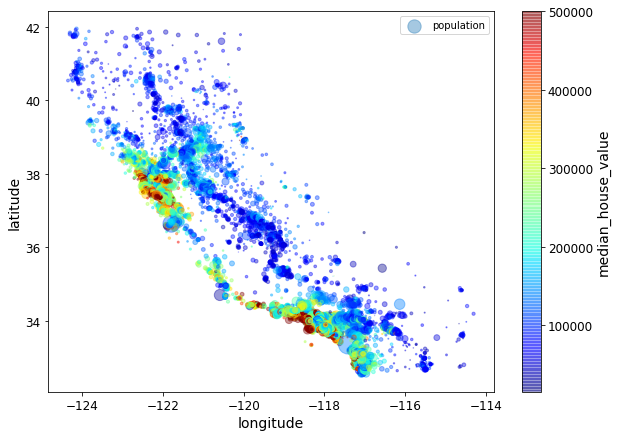

In [31]:
housing.plot(kind="scatter", x="longitude", y="latitude", alpha=0.4,
    s=housing["population"]/100, label="population", figsize=(10,7),
    c="median_house_value", cmap=plt.get_cmap("jet"), colorbar=True,
    sharex=False)
plt.legend()

We can superimpose this illustration onto a map of California:

In [33]:
# Download the California image
images_path = os.path.join(PROJECT_ROOT_DIR, "images", "end_to_end_project")
os.makedirs(images_path, exist_ok=True)
DOWNLOAD_ROOT = "https://raw.githubusercontent.com/ageron/handson-ml2/master/"
filename = "california.png"
print("Downloading", filename)
url = DOWNLOAD_ROOT + "images/end_to_end_project/" + filename
urllib.request.urlretrieve(url, os.path.join(images_path, filename))

('./images/end_to_end_project/california.png',
 <http.client.HTTPMessage at 0x7f861add3290>)

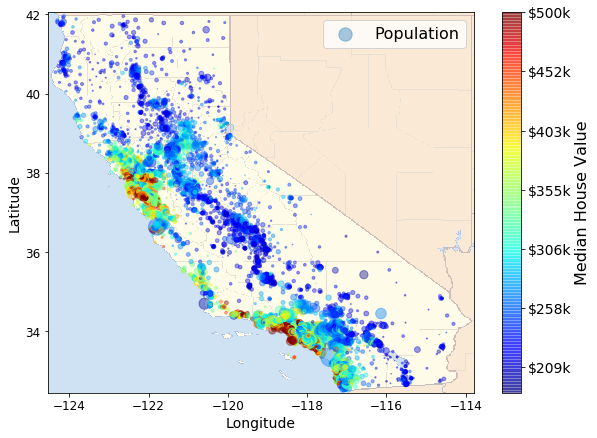

In [34]:
import matplotlib.image as mpimg
california_img=mpimg.imread(os.path.join(images_path, filename))
ax = housing.plot(kind="scatter", x="longitude", y="latitude", figsize=(10,7),
                       s=housing['population']/100, label="Population",
                       c="median_house_value", cmap=plt.get_cmap("jet"),
                       colorbar=False, alpha=0.4,
                      )
plt.imshow(california_img, extent=[-124.55, -113.80, 32.45, 42.05], alpha=0.5,
           cmap=plt.get_cmap("jet"))
plt.ylabel("Latitude", fontsize=14)
plt.xlabel("Longitude", fontsize=14)

prices = housing["median_house_value"]
tick_values = np.linspace(prices.min(), prices.max(), 11)
cbar = plt.colorbar(ticks=tick_values/prices.max())
cbar.ax.set_yticklabels(["$%dk"%(round(v/1000)) for v in tick_values], fontsize=14)
cbar.set_label('Median House Value', fontsize=16)

plt.legend(fontsize=16)
#save_fig("california_housing_prices_plot")
plt.show()

We can also understand feature correlations and plot these correlations.

In [35]:
corr_matrix = housing.corr()

In [36]:
corr_matrix["median_house_value"].sort_values(ascending=False)

median_house_value    1.000000
median_income         0.688075
total_rooms           0.134153
housing_median_age    0.105623
households            0.065843
total_bedrooms        0.049686
population           -0.024650
longitude            -0.045967
latitude             -0.144160
Name: median_house_value, dtype: float64

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f861adf7d10>,
      dtype=object)

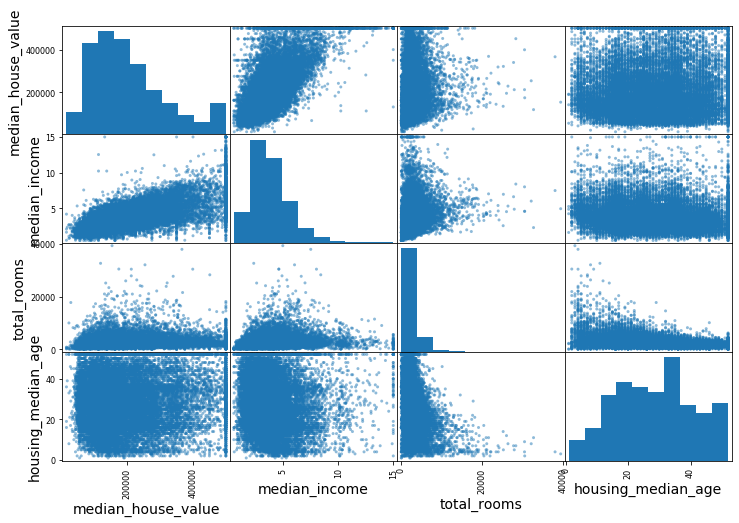

In [37]:
from pandas.plotting import scatter_matrix

attributes = ["median_house_value", "median_income", "total_rooms",
              "housing_median_age"]
scatter_matrix(housing[attributes], figsize=(12, 8))
#save_fig("scatter_matrix_plot")

[0, 16, 0, 550000]

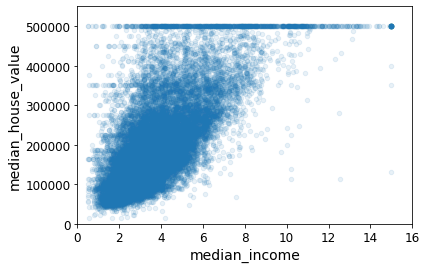

In [38]:
housing.plot(kind="scatter", x="median_income", y="median_house_value",
             alpha=0.1)
plt.axis([0, 16, 0, 550000])

Relationships like these encourage us to do some mild feature manipulations such as the following:

In [39]:
housing["rooms_per_household"] = housing["total_rooms"]/housing["households"]
housing["bedrooms_per_room"] = housing["total_bedrooms"]/housing["total_rooms"]
housing["population_per_household"]=housing["population"]/housing["households"]

In [40]:
corr_matrix = housing.corr()
corr_matrix["median_house_value"].sort_values(ascending=False)

median_house_value          1.000000
median_income               0.688075
rooms_per_household         0.151948
total_rooms                 0.134153
housing_median_age          0.105623
households                  0.065843
total_bedrooms              0.049686
population_per_household   -0.023737
population                 -0.024650
longitude                  -0.045967
latitude                   -0.144160
bedrooms_per_room          -0.255880
Name: median_house_value, dtype: float64

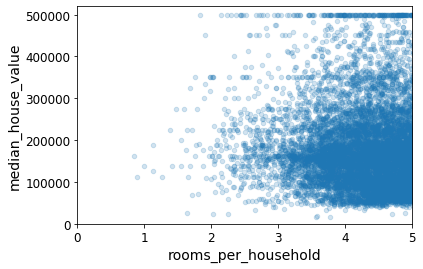

In [41]:
housing.plot(kind="scatter", x="rooms_per_household", y="median_house_value",
             alpha=0.2)
plt.axis([0, 5, 0, 520000])
plt.show()

In [42]:
housing.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,rooms_per_household,bedrooms_per_room,population_per_household
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909,5.429000,0.213039,3.070655
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874,2.474173,0.057983,10.386050
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000,0.846154,0.100000,0.692308
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000,4.440716,0.175427,2.429741
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000,5.229129,0.203162,2.818116
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000,6.052381,0.239821,3.282261
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000,141.909091,1.000000,1243.333333


### 1.4 Preparing the data for ML
Given the above exploratory analysis, we would now like to take the dataset and automate a process for generating train/test data for predictions.

First we will drop the labels from the stratified train set:

In [43]:
housing = strat_train_set.drop("median_house_value", axis=1) # drop labels for training set
housing_labels = strat_train_set["median_house_value"].copy()

Next we will deal with the NaN rows in any column.

In [44]:
sample_incomplete_rows = housing[housing.isnull().any(axis=1)].head() # removes samples with missing entries in a row
sample_incomplete_rows

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity
4629,-118.30,34.07,18.0,3759.0,NaN,3296.0,1462.0,2.2708,<1H OCEAN
6068,-117.86,34.01,16.0,4632.0,NaN,3038.0,727.0,5.1762,<1H OCEAN
17923,-121.97,37.35,30.0,1955.0,NaN,999.0,386.0,4.6328,<1H OCEAN
13656,-117.30,34.05,6.0,2155.0,NaN,1039.0,391.0,1.6675,INLAND
19252,-122.79,38.48,7.0,6837.0,NaN,3468.0,1405.0,3.1662,<1H OCEAN


There are various ways of dealing with the NaNs, one is to fill with the median, which can be done explicitly or via a sklearn imputer.

In [45]:
# Replacing the NaN in total bedrooms 
median = housing["total_bedrooms"].median()
sample_incomplete_rows["total_bedrooms"].fillna(median, inplace=True) # option 3

In [46]:
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(strategy="median")

The median only makes sense over numeric features so we remove non-numeric features for the median imputer.

In [47]:
housing_num = housing.drop("ocean_proximity", axis=1)

In [48]:
imputer.fit(housing_num)

SimpleImputer(add_indicator=False, copy=True, fill_value=None,
              missing_values=nan, strategy='median', verbose=0)

The impute statistics inform the median value of each column that will be inserted.  We can also manually check this value.

In [59]:
print('Imputer strategy: ', imputer.strategy)
print(imputer.statistics_)
# Test for entrywise equality.
assert np.array_equal(imputer.statistics_, housing_num.median().values)

Imputer strategy:  median
[-118.51     34.26     29.     2119.5     433.     1164.      408.
    3.5409]


At this point we are able to transform the data to numpy arrays which are a little easier to handle when we are not calling sklearn fitting methods.

In [56]:
X = imputer.transform(housing_num)
housing_tr = pd.DataFrame(X, columns=housing_num.columns,
                          index=housing.index)

Now we can check how the data looks on the rows that have had the imputed values inserted into the array.

In [57]:
housing_tr.loc[sample_incomplete_rows.index.values]

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income
4629,-118.30,34.07,18.0,3759.0,433.0,3296.0,1462.0,2.2708
6068,-117.86,34.01,16.0,4632.0,433.0,3038.0,727.0,5.1762
17923,-121.97,37.35,30.0,1955.0,433.0,999.0,386.0,4.6328
13656,-117.30,34.05,6.0,2155.0,433.0,1039.0,391.0,1.6675
19252,-122.79,38.48,7.0,6837.0,433.0,3468.0,1405.0,3.1662


At this point we can reintroduce the categoric feature which we will convert to numeric vectors under an Ordinal Encoder from Sklearn.

In [61]:
from sklearn.preprocessing import OrdinalEncoder

In [63]:
housing_cat = housing[["ocean_proximity"]]
housing_cat.head(10)

,ocean_proximity
17606,<1H OCEAN
18632,<1H OCEAN
14650,NEAR OCEAN
3230,INLAND
3555,<1H OCEAN
19480,INLAND
8879,<1H OCEAN
13685,INLAND
4937,<1H OCEAN
4861,<1H OCEAN


In [64]:
ordinal_encoder = OrdinalEncoder()
housing_cat_encoded = ordinal_encoder.fit_transform(housing_cat)
housing_cat_encoded[:10]

array([[0.],
       [0.],
       [4.],
       [1.],
       [0.],
       [1.],
       [0.],
       [1.],
       [0.],
       [0.]])

We can see the encoding that has been used here:

In [73]:
for a,b in zip(range(len(ordinal_encoder.categories_[0])),ordinal_encoder.categories_[0]):
    print(a,b)

0 <1H OCEAN
1 INLAND
2 ISLAND
3 NEAR BAY
4 NEAR OCEAN


Alternatively we can use a one hot encoder.

The `OneHotEncoder` returns a sparse array by default. This can be changed to a dense array as follows (or by choosing `sparse=False` in the initialisation):

In [75]:
from sklearn.preprocessing import OneHotEncoder

In [77]:
cat_encoder = OneHotEncoder(sparse=False)
housing_cat_1hot = cat_encoder.fit_transform(housing_cat)
housing_cat_1hot

array([[1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1.],
       ...,
       [0., 1., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0.]])

All of this can be wrapped into a custom transformer.

In [78]:
from sklearn.base import BaseEstimator, TransformerMixin

# column index
rooms_ix, bedrooms_ix, population_ix, households_ix = 3, 4, 5, 6

class CombinedAttributesAdder(BaseEstimator, TransformerMixin):
    def __init__(self, add_bedrooms_per_room = True): # no *args or **kargs
        self.add_bedrooms_per_room = add_bedrooms_per_room
    def fit(self, X, y=None):
        return self  # nothing else to do
    def transform(self, X):
        rooms_per_household = X[:, rooms_ix] / X[:, households_ix]
        population_per_household = X[:, population_ix] / X[:, households_ix]
        if self.add_bedrooms_per_room:
            bedrooms_per_room = X[:, bedrooms_ix] / X[:, rooms_ix]
            return np.c_[X, rooms_per_household, population_per_household,
                         bedrooms_per_room]
        else:
            return np.c_[X, rooms_per_household, population_per_household]

attr_adder = CombinedAttributesAdder(add_bedrooms_per_room=False)
housing_extra_attribs = attr_adder.transform(housing.values)

In [79]:
housing_extra_attribs = pd.DataFrame(
    housing_extra_attribs,
    columns=list(housing.columns)+["rooms_per_household", "population_per_household"],
    index=housing.index)
housing_extra_attribs.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity,rooms_per_household,population_per_household
17606,-121.89,37.29,38,1568,351,710,339,2.7042,<1H OCEAN,4.62537,2.0944
18632,-121.93,37.05,14,679,108,306,113,6.4214,<1H OCEAN,6.00885,2.70796
14650,-117.2,32.77,31,1952,471,936,462,2.8621,NEAR OCEAN,4.22511,2.02597
3230,-119.61,36.31,25,1847,371,1460,353,1.8839,INLAND,5.23229,4.13598
3555,-118.59,34.23,17,6592,1525,4459,1463,3.0347,<1H OCEAN,4.50581,3.04785


All of this can be automated through a `sklearn pipeline`:

In [81]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

We begin with the numeric pipeline.

In [82]:
num_pipeline = Pipeline([
        ('imputer', SimpleImputer(strategy="median")),
        ('attribs_adder', CombinedAttributesAdder()),
        ('std_scaler', StandardScaler()),
    ])

We take as input the numeric housing data (i.e. with ocean proximity dropped) `housing_num` and push it through the numeric pipeline.

At this point we can add a second transformer which will deal with the categoric columns.

In [83]:
from sklearn.compose import ColumnTransformer

In [109]:
housing

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity
17606,-121.89,37.29,38.0,1568.0,351.0,710.0,339.0,2.7042,<1H OCEAN
18632,-121.93,37.05,14.0,679.0,108.0,306.0,113.0,6.4214,<1H OCEAN
14650,-117.20,32.77,31.0,1952.0,471.0,936.0,462.0,2.8621,NEAR OCEAN
3230,-119.61,36.31,25.0,1847.0,371.0,1460.0,353.0,1.8839,INLAND
3555,-118.59,34.23,17.0,6592.0,1525.0,4459.0,1463.0,3.0347,<1H OCEAN
...,...,...,...,...,...,...,...,...,...
6563,-118.13,34.20,46.0,1271.0,236.0,573.0,210.0,4.9312,INLAND
12053,-117.56,33.88,40.0,1196.0,294.0,1052.0,258.0,2.0682,INLAND
13908,-116.40,34.09,9.0,4855.0,872.0,2098.0,765.0,3.2723,INLAND
11159,-118.01,33.82,31.0,1960.0,380.0,1356.0,356.0,4.0625,<1H OCEAN


In [84]:
num_attribs = list(housing_num)
cat_attribs = ["ocean_proximity"]

full_pipeline = ColumnTransformer([
        ("num", num_pipeline, num_attribs),
        ("cat", OneHotEncoder(), cat_attribs),
    ])

housing_prepared = full_pipeline.fit_transform(housing)

In [85]:
housing_prepared.shape

(16512, 16)

In [110]:
housing_prepared[0,:]

array([-1.15604281,  0.77194962,  0.74333089, -0.49323393, -0.44543821,
       -0.63621141, -0.42069842, -0.61493744, -0.31205452, -0.08649871,
        0.15531753,  1.        ,  0.        ,  0.        ,  0.        ,
        0.        ])

Now that the preparation steps are complete we will separate the data into training and test sets that we want to use later for various different types of algorithms.

In [99]:
# Training and validation sets.
train = strat_train_set.drop("median_house_value", axis=1) # drop labels for training set
train_labels = strat_train_set["median_house_value"].copy()

# Put the training set through the transformer before getting validation set
train_set_transformed = full_pipeline.fit_transform(train)

X_housing_transformed = train_set_transformed
y_housing_transformed = train_labels / np.linalg.norm(train_labels)
X_train, X_val, y_train, y_val = train_test_split(train_set_transformed, train_labels, test_size=0.2, random_state=42)
print(f'Train Transformed sizes: {X_housing_transformed.shape, y_housing_transformed.shape}')
print(f'Training sizes: {X_train.shape, y_train.shape}')
print(f'Validation size: {X_val.shape, y_val.shape}')
y_train /= np.linalg.norm(y_train)
y_val /= np.linalg.norm(y_val)


# Testing set to evaluate model performance.
test = strat_test_set.drop("median_house_value", axis=1) # drop labels for testing set
test_labels = strat_test_set["median_house_value"].copy()
X_test = full_pipeline.fit_transform(test)
y_test = test_labels / np.linalg.norm(test_labels)


print(f'Testing size: {X_test.shape, y_test.shape}')

Train Transformed sizes: ((16512, 16), (16512,))
Training sizes: ((13209, 16), (13209,))
Validation size: ((3303, 16), (3303,))
Testing size: ((4128, 16), (4128,))


Now let's save each of the arrays so that we can access them easily in the model fitting pipeline.
We will save data in the format:
$$array = [X,y]$$
so that the targets are always the final column of the saved array.;

In [103]:
fpath = 'datasets/'
np.save(fpath+'train_transformed.npy', np.c_[X_housing_transformed,y_housing_transformed])
np.save(fpath+'transformed_training_set.npy', np.c_[train_set_transformed,train_labels/np.linalg.norm(train_labels)])
np.save(fpath+'train.npy', np.c_[X_train,y_train])
np.save(fpath+'validate.npy', np.c_[X_val,y_val])
np.save(fpath+'test.npy', np.c_[X_test,y_test])

Then we can load these in as follows:

In [102]:
arr_checks = [(X_housing_transformed,y_housing_transformed),(X_train, y_train), (X_val,y_val), (X_test,y_test)]
for i,fi in enumerate(['train_transformed.npy','train.npy', 'validate.npy', 'test.npy']):
    arr = np.load(fpath+fi)
    _X,_y = arr[:,:-1], arr[:,-1]
    assert np.array_equal(_X, arr_checks[i][0])
    assert np.array_equal(_y, arr_checks[i][1])

In [104]:
from sklearn.linear_model import Ridge
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer

In [105]:
param_grid = [
    {'alpha' : [0] + [2**i for i in range(-10,10)]}
]

def mean_square_loss(y_true, y_pred):
    diff = np.linalg.norm(y_true - y_pred)/len(y_true)
    return diff

my_score = make_scorer(mean_square_loss, greater_is_better=False)

In [111]:
ridge = Ridge()
grid_search = GridSearchCV(
            ridge,param_grid,cv=5,
            scoring=make_scorer(mean_square_loss,greater_is_better=False),
            verbose=2,
            return_train_score=True,)
grid_search.fit(housing_prepared,train_labels/np.linalg.norm(train_labels))

Fitting 5 folds for each of 21 candidates, totalling 105 fits
[CV] alpha=0 .........................................................
[CV] .......................................... alpha=0, total=   0.0s
[CV] alpha=0 .........................................................
[CV] .......................................... alpha=0, total=   0.0s
[CV] alpha=0 .........................................................
[CV] .......................................... alpha=0, total=   0.0s
[CV] alpha=0 .........................................................
[CV] .......................................... alpha=0, total=   0.0s
[CV] alpha=0 .........................................................
[CV] .......................................... alpha=0, total=   0.0s
[CV] alpha=0.0009765625 ..............................................
[CV] ............................... alpha=0.0009765625, total=   0.0s
[CV] alpha=0.0009765625 ..............................................
[CV] ..........

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
/Users/charlied/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=5.34888e-17): result may not be accurate.
  overwrite_a=True).T
/Users/charlied/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.78858e-17): result may not be accurate.
  overwrite_a=True).T
/Users/charlied/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=1.19155e-17): result may not be accurate.
  overwrite_a=True).T
/Users/charlied/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.06511e-17): result may not be accurate.
  overwrite_a=True).T


[CV] ................................. alpha=0.00390625, total=   0.0s
[CV] alpha=0.0078125 .................................................
[CV] .................................. alpha=0.0078125, total=   0.0s
[CV] alpha=0.0078125 .................................................
[CV] .................................. alpha=0.0078125, total=   0.0s
[CV] alpha=0.0078125 .................................................
[CV] .................................. alpha=0.0078125, total=   0.0s
[CV] alpha=0.0078125 .................................................
[CV] .................................. alpha=0.0078125, total=   0.0s
[CV] alpha=0.0078125 .................................................
[CV] .................................. alpha=0.0078125, total=   0.0s
[CV] alpha=0.015625 ..................................................
[CV] ................................... alpha=0.015625, total=   0.0s
[CV] alpha=0.015625 ..................................................
[CV] .

[Parallel(n_jobs=1)]: Done 105 out of 105 | elapsed:    0.6s finished


GridSearchCV(cv=5, error_score=nan,
             estimator=Ridge(alpha=1.0, copy_X=True, fit_intercept=True,
                             max_iter=None, normalize=False, random_state=None,
                             solver='auto', tol=0.001),
             iid='deprecated', n_jobs=None,
             param_grid=[{'alpha': [0, 0.0009765625, 0.001953125, 0.00390625,
                                    0.0078125, 0.015625, 0.03125, 0.0625, 0.125,
                                    0.25, 0.5, 1, 2, 4, 8, 16, 32, 64, 128, 256,
                                    512]}],
             pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
             scoring=make_scorer(mean_square_loss, greater_is_better=False),
             verbose=2)

(Sklearn) Optimal hyperparameter:  {'alpha': 64}


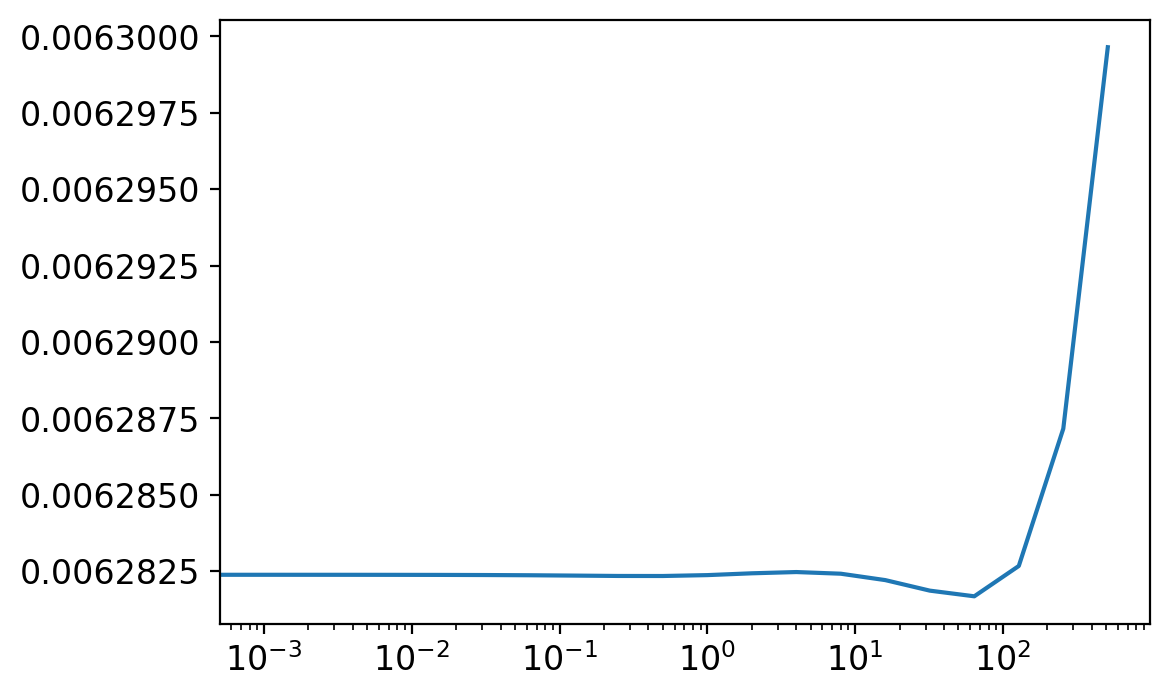

In [112]:
print('(Sklearn) Optimal hyperparameter: ', grid_search.best_params_)

fig,ax = plt.subplots(dpi=200)
ax.plot(param_grid[0]['alpha'],np.sqrt(-grid_search.cv_results_['mean_test_score']))
ax.set_xscale('log')